# Logistic Regression Classification with MLFLOW integration
**Author:** Ramiro Predassi
**Date:** June 2025

## Table of Contents
1. Data Sources
2. Exploratory Data Analysis
    1. Missing Values
    2. Numerical Variables
    3. Distribution of numerical features
    4. Categorical Variables
    5. Cardinality of Categorical Variables
    6. Outliers
    7. Realtionships between independent and dependent feature
3. Pre Processing
    1. Test Data Transformations
    2. Train Data Transformations
4. Logistic Regression classificator
    1. Hyper parameter search
    2. Model Training
    3. Evaluation
5. MLFLOW Tracking
   1. Loading Model as a Python function

In [49]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn

In [50]:
## Set tracking URI
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

## Data Sources
**Data:** The data I will use for this project is available on https://www.kaggle.com/competitions/spaceship-titanic/data

In [51]:
# This next function allows me to retain in the memory the paths to the data in the form of a list
# So in the future is easier to read them as DataFrame

In [52]:
def get_filenames(filepath)->list:
    """ 
    This function retrives all filenames in the directory
    of choice and returns a list of absolute_path as string

    Parameters:
        filepath (str): relative path of directory

    Return:
        files (list): list of absolute paths for each file in
        the selected path
        filenames (list): List of name of CSV files found in the
        folder.
    """
    path = Path(filepath).resolve()
    files = []
    filenames = []
    for file in path.rglob('*.csv'):
        files.append(str(file.resolve()))
        filenames.append(str(file.name))

    return files, filenames

csv_files, csv_filenames = get_filenames("spaceship-titanic")

In [53]:
test_data = pd.read_csv(csv_files[0])

In [54]:
train_data = pd.read_csv(csv_files[1])

## EDA

### Preliminary analysis

In [55]:
print("Shape of Train Dataset with rows and columns")
print(train_data.shape)

Shape of Train Dataset with rows and columns
(8693, 14)


In [56]:
# Data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [57]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [58]:
# Unique values for each column
print(train_data.nunique())

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64


In [59]:
# Pickig a record as example
train_data.loc[12]

PassengerId          0009_01
HomePlanet              Mars
CryoSleep              False
Cabin                  F/1/P
Destination      TRAPPIST-1e
Age                     32.0
VIP                    False
RoomService             73.0
FoodCourt                0.0
ShoppingMall          1123.0
Spa                      0.0
VRDeck                 113.0
Name            Berers Barne
Transported             True
Name: 12, dtype: object

In [60]:
# Very important to know the balance of de independent feature
train_data['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [61]:
# Later on model training we can use 'Accuracy' to fit our model due to the almost perfect balance between True and False

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Missing Values

In [62]:
# List of columns with Null values
columns_with_na = [features for features in train_data.columns if train_data[features].isnull().sum()>1]
# Printing % of null values for each column
for feature in columns_with_na:
    print(feature,np.round(train_data[feature].isnull().mean(),4), "% of NaN")

HomePlanet 0.0231 % of NaN
CryoSleep 0.025 % of NaN
Cabin 0.0229 % of NaN
Destination 0.0209 % of NaN
Age 0.0206 % of NaN
VIP 0.0234 % of NaN
RoomService 0.0208 % of NaN
FoodCourt 0.0211 % of NaN
ShoppingMall 0.0239 % of NaN
Spa 0.0211 % of NaN
VRDeck 0.0216 % of NaN
Name 0.023 % of NaN


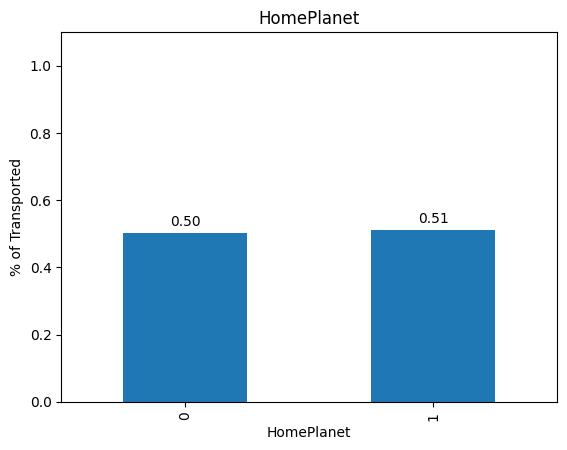

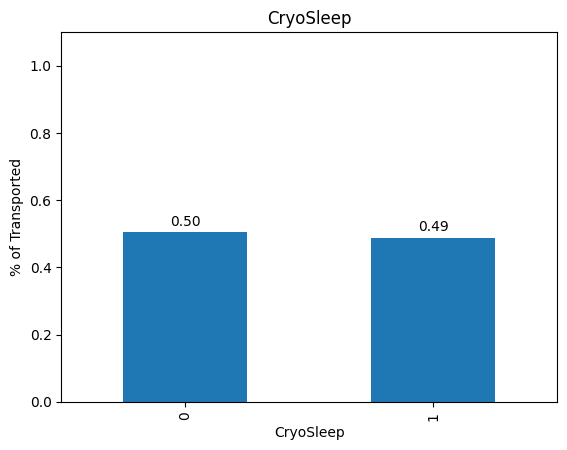

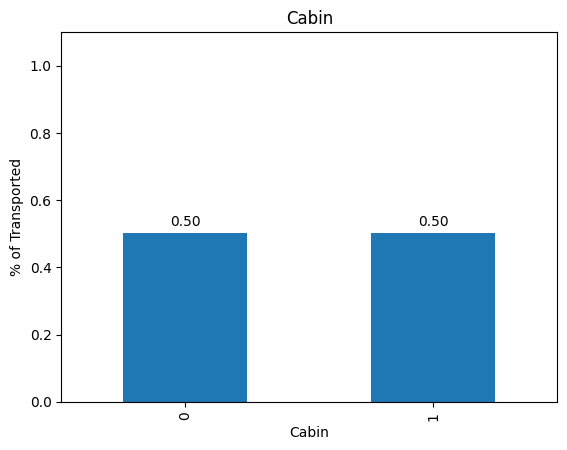

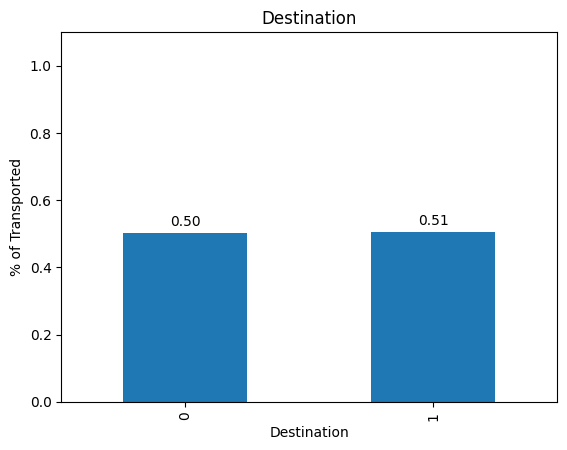

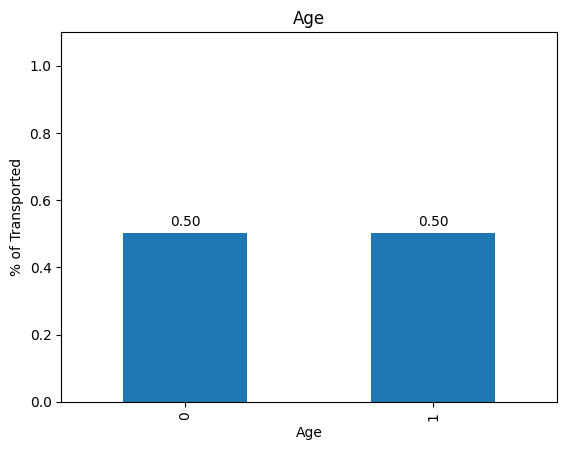

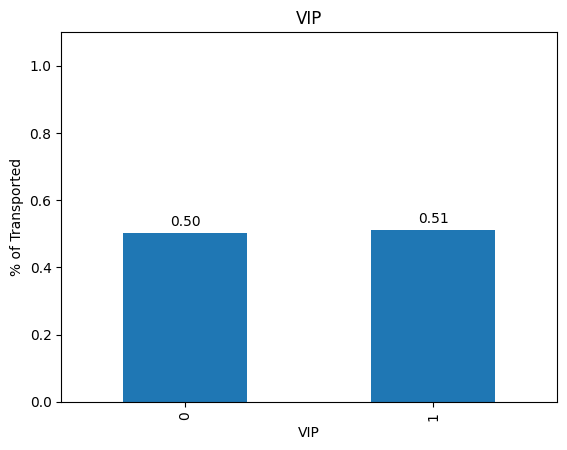

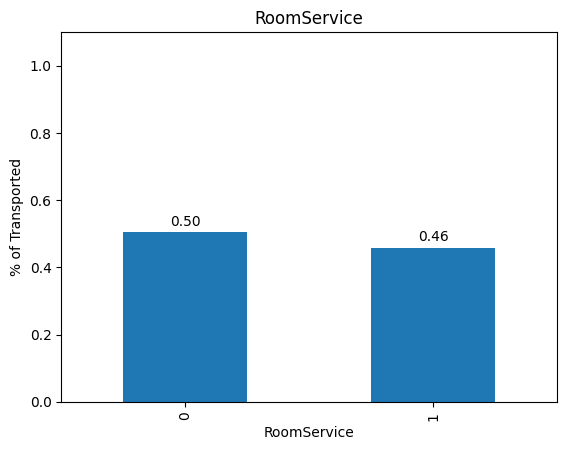

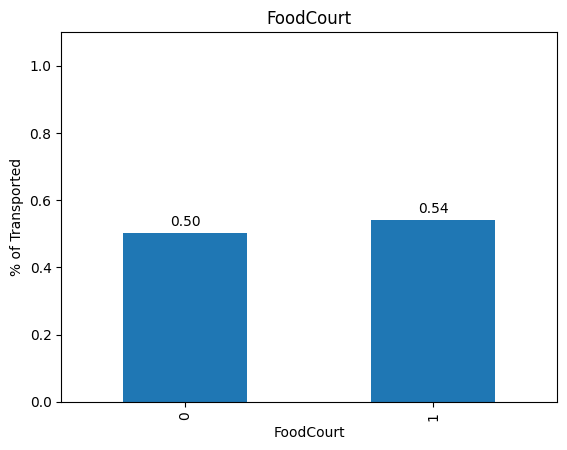

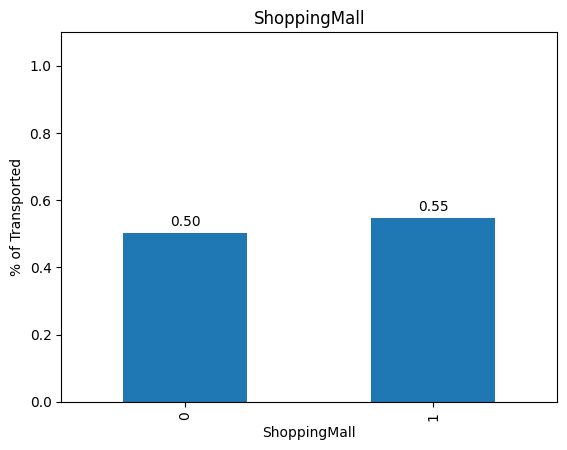

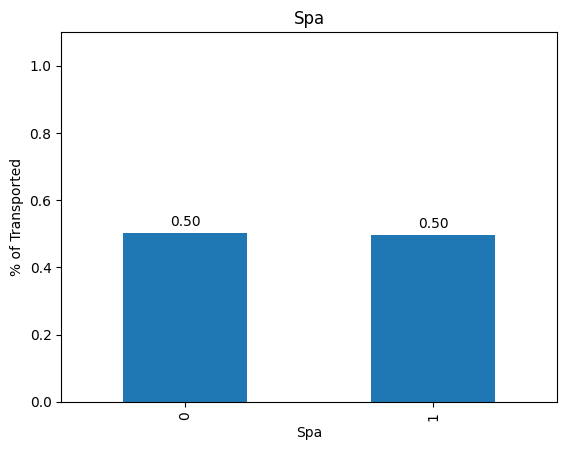

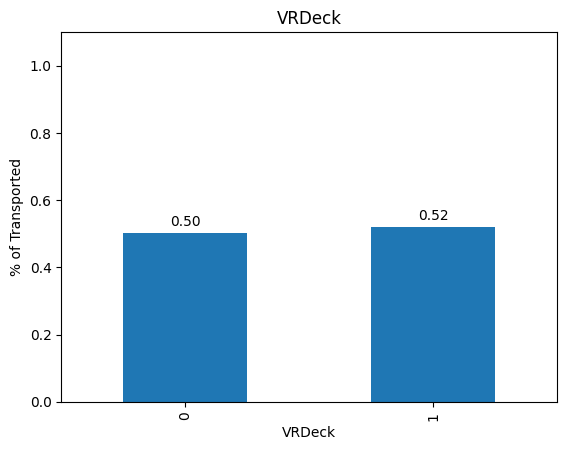

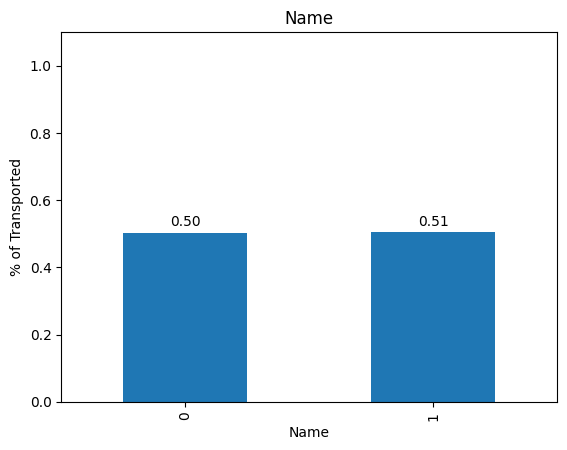

In [63]:
# Checking the importance of this rows and columns against our dependent feature
for feature in columns_with_na:
    df = train_data.copy()
    df['Transported'] = df['Transported'].astype(int) 
    # Creating a variable that indicates if there is a missing value (1) in the observation or not (0)
    df[feature] = np.where(df[feature].isnull(),1,0)
    # Plotting the information
    means = df.groupby(feature)['Transported'].mean()
    ax = means.plot.bar()
    plt.title(feature)
    plt.ylabel("% of Transported")
    plt.ylim(0, 1.1)
    for i, val in enumerate(means):
        ax.text(i, val + 0.02, f"{val:.2f}", ha='center')
    plt.show()


The results of all features having almost 50 - 50 % of proportion we can delete NaN rows because they don't have any valuable information for the prediction of
my dependent Variable 'Transported'

In [64]:
# Dropping NaN Values
train_data = train_data.dropna().reset_index(drop=True)

### Numerical Values

In [65]:
# Numerical Features
numerical_features = [feature for feature in train_data.columns if train_data[feature].dtypes != 'object' and feature != 'Transported']

train_data[numerical_features].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


### Distribution of Numerical Features (High Cardinality)

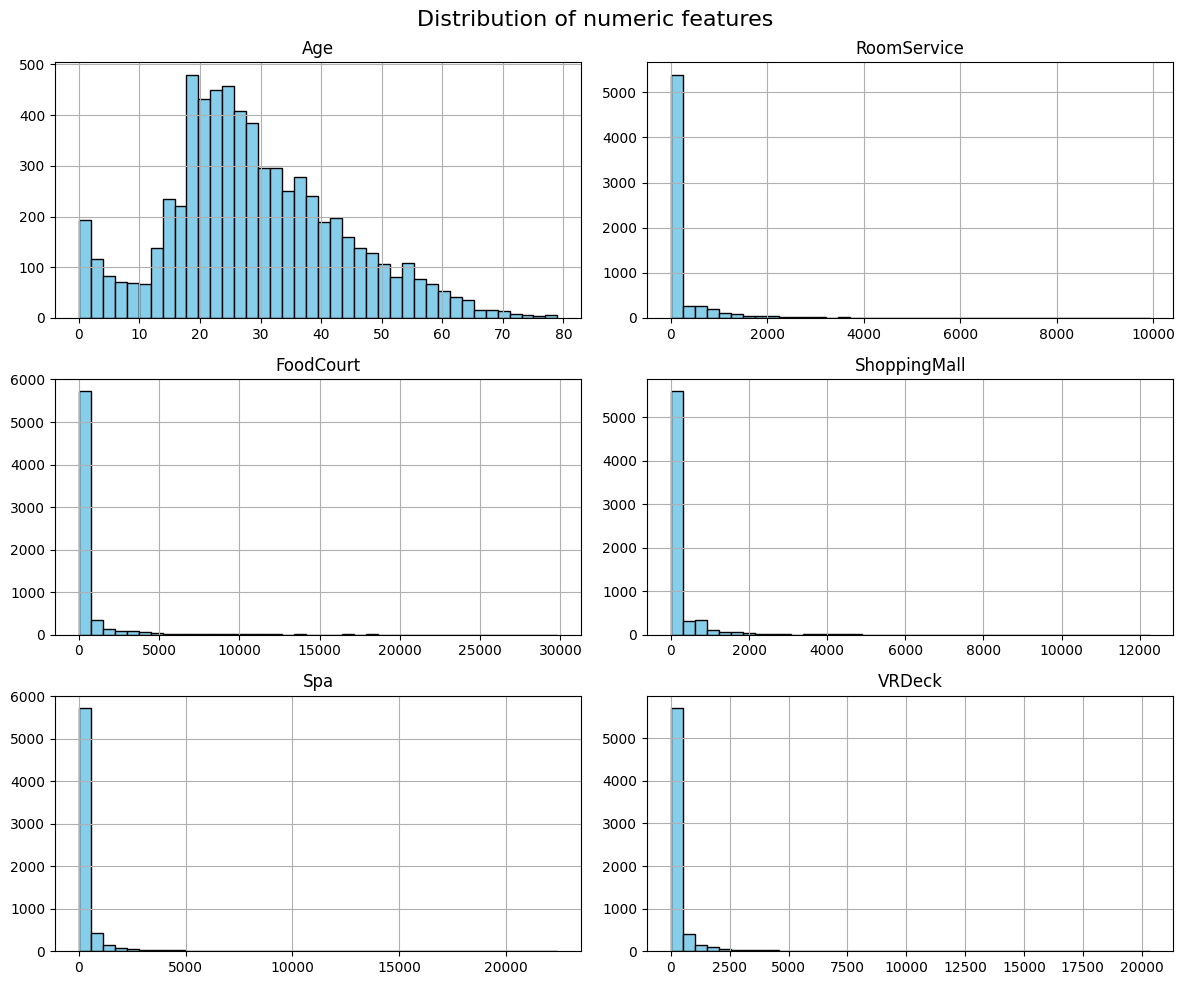

In [66]:
# Filtering if 0 or NaN in numerical features
num_df = train_data[numerical_features]
filtered_df = num_df[~((num_df == 0) | num_df.isnull()).all(axis=1)]
# Plotting distribution of numerical features
train_data[numerical_features].hist(bins=40, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of numeric features", fontsize=16)
plt.tight_layout()
plt.show()

##### This distribution represent a right skewed raw data, meaning the data distribution is not symmetrical. This skewness suggests that the median is likely a more representative measure of central tendency than the mean for this dataset. This characteristic will be considered during feature engineering and model selection to ensure robust analysis.

#### Skewed transformation

In [67]:
def transform_skewed_features(df,exclude=[],method='yeo-johnson', skew_threshold=1):
    """
    This function applies Yeo-Johnson trnasformation to all skewed
    features.

    Parameters:
        df (pd.DataFrame): Original DataFrame
        exclude (list): List of columns to be excluded, like dependent feature.
        method (str): 'yeo-johnson' (default) or 'box-cox'.
        skew_threshold (float): Applies only if the skewed is higher.
    
    Returns:
        pd.DataFrame: Transformed dataframe.
    """
    df = df.copy()
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'object' and feature not in exclude]

    for feature in numerical_features:
        # Checking for null columns
        if df[feature].isnull().all():
            continue  
        skew = df[feature].skew()
        if abs(skew) > skew_threshold:
            non_null_idx = df[feature].notnull()            
            # Reshaping PowerTransformer
            reshaped = df.loc[non_null_idx, feature].values.reshape(-1, 1)
            try:
                pt = PowerTransformer(method=method, standardize=False)
                df.loc[non_null_idx, feature] = pt.fit_transform(reshaped)
            except ValueError as e:
                print(f' Transformation can not be done "{feature}": {e}')

    return df

In [68]:
# Unique values for each column
print(train_data[numerical_features].nunique())

Age               80
RoomService     1093
FoodCourt       1293
ShoppingMall     984
Spa             1143
VRDeck          1106
dtype: int64


In [69]:
train_data = transform_skewed_features(train_data,'Transported',method='yeo-johnson')

### Categorical Values

In [70]:
# Categorical Features
categorical_features = [feature for feature in train_data.columns if train_data[feature].dtypes == 'O' and feature != 'Transported']

train_data[categorical_features].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


### Cardinality of Categorical Values

In [71]:
for feature in categorical_features:
    print(f'The feature is {feature} and number of categories: {len(train_data[feature].unique())}')

The feature is PassengerId and number of categories: 6606
The feature is HomePlanet and number of categories: 3
The feature is CryoSleep and number of categories: 2
The feature is Cabin and number of categories: 5305
The feature is Destination and number of categories: 3
The feature is VIP and number of categories: 2
The feature is Name and number of categories: 6590


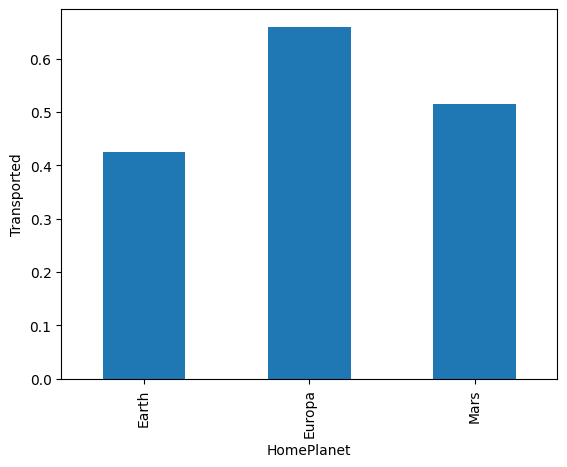

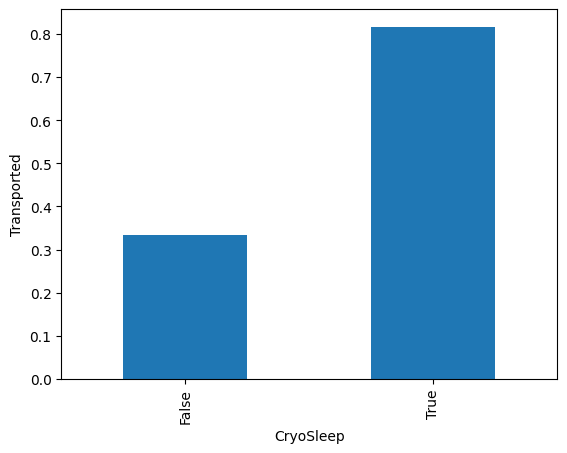

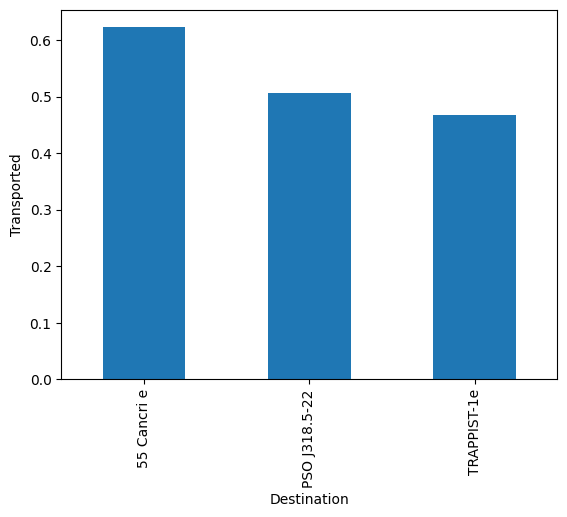

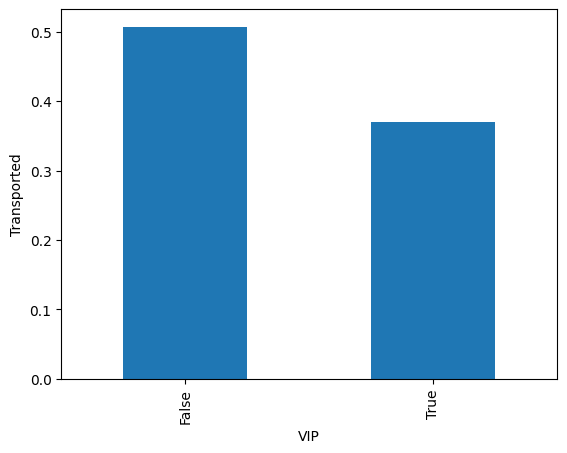

In [72]:
# Plotting Mean of transported across each categorical feature
filtered_categorical = [feature for feature in categorical_features if feature not in ['PassengerId','Cabin','Name']]
for feature in filtered_categorical:
    df = train_data.copy()
    df.groupby(feature)['Transported'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Transported')
    plt.show()

##### Conclusion
1. Homeplanet: more than 50% of people coming from mars and Europe have been transported to another dimension
2. CryoSleep: 80% of people in cryosleep has been transported to another dimension (Very important feature for prediction)
3. Destination: Shows that 60% of people going to Cancri has been transported
4. VIP: it shows theare are no clear distiction between VIP or Normal people

### Outliers

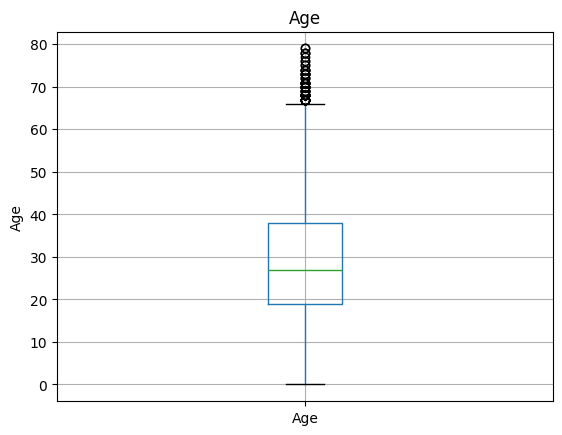

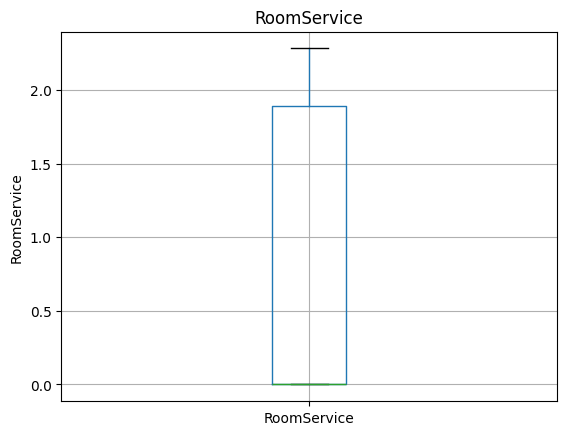

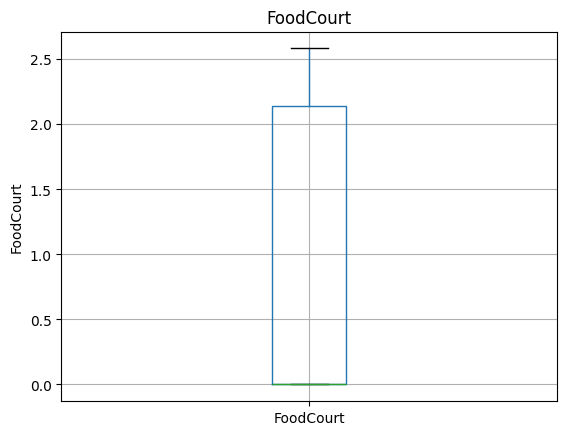

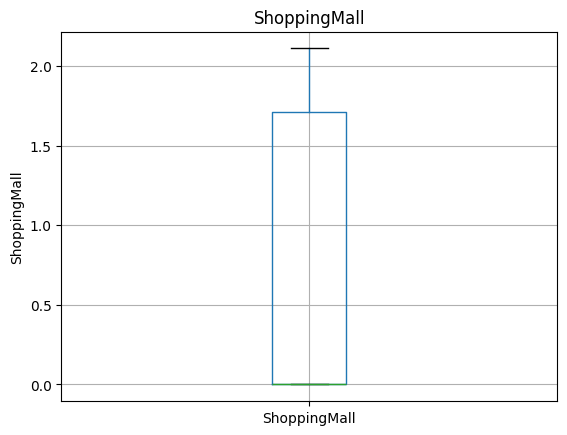

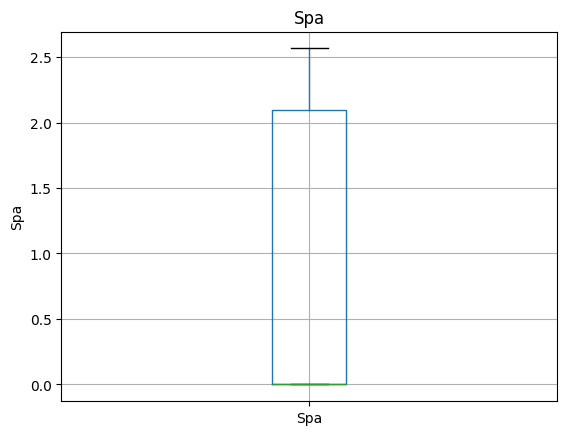

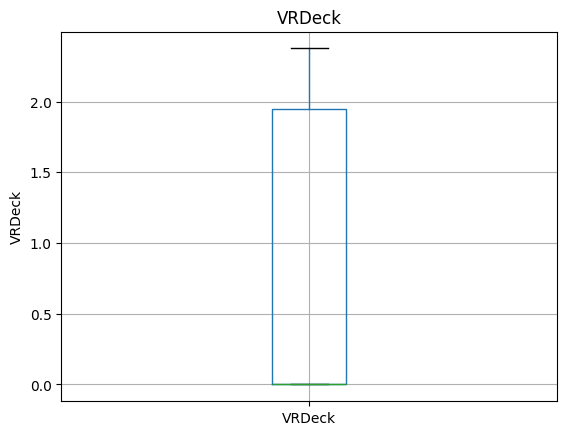

In [73]:
for feature in numerical_features:
    df = train_data.copy()
    df.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

#### Conclusion: there are only some outliers in the Age column

### Realtionships between independent and dependent feature

In [74]:
df_encoded = pd.get_dummies(train_data, columns=filtered_categorical, drop_first=True)

In [75]:
# Convert bool to int
for col in df_encoded.select_dtypes(include='bool').columns:
    df_encoded[col] = df_encoded[col].astype(int)

In [76]:
num_df = df_encoded.select_dtypes(include=[np.number])
correlations = num_df.corr()['Transported'].sort_values(ascending=False)
corr_matrix = num_df.corr()

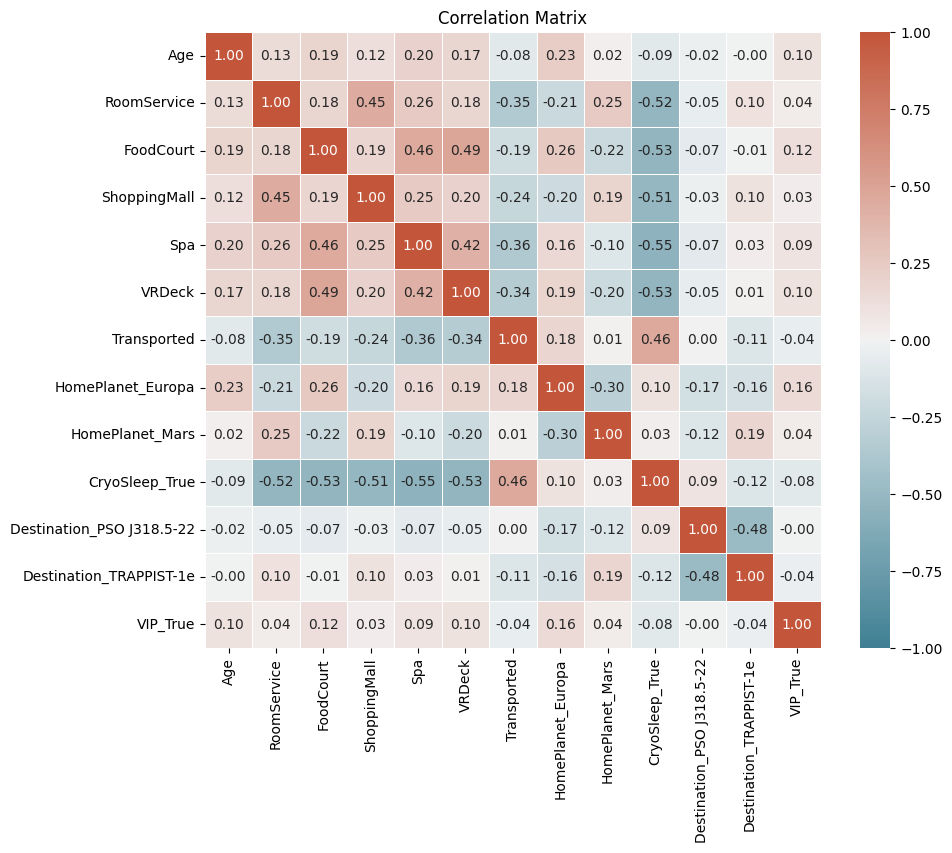

In [77]:
# Plotting Correlation Matrix
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, annot=True, fmt=".2f", linewidths=.5, ax=ax)
plt.title('Correlation Matrix')
plt.show()

#### Conclusion:
- CryoSleep_True (r ≈ 0.463). Strongest single predictor. Binary, easy to interpret (passengers in cryosleep are far more likely to be transported).
- Spa (r ≈ –0.361) Among the “spend” variables, Spa‐spending has the next largest absolute correlation. Negative sign means higher spa spend → lower transported rate.
- RoomService (r ≈ –0.354). Also strongly predictive and captures a different aspect of passenger behavior.
- VRDeck (r ≈ –0.335). Rounds out your “amenities spend” predictors with high relevance.
- ShoppingMall (r ≈ –0.235). Adds further nuance from a spend dimension that isn’t entirely collinear with the others.
- HomePlanet_Europa (r ≈ 0.182). Captures a demographic effect; simple dummy and low risk of multicollinearity.

##### Why these?
- Absolute correlation threshold: I’ve focused on features with |r| > 0.20, since below that the incremental predictive power is limited in a linear model.
- Multicollinearity check: None of the chosen pairs exceed ~0.50 between themselves (e.g. Spa–VRDeck ≈ 0.42), which is acceptable.

## Pre Processing

### Test Data Transformations

In [78]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [79]:
# Dropping NaN Values
test_data = test_data.dropna().reset_index(drop=True)

In [80]:
# Skewed transformation of data
test_data = transform_skewed_features(test_data,'Transported',method='yeo-johnson')

In [81]:
# Dummies
df_test_data = pd.get_dummies(test_data, columns=filtered_categorical, drop_first=True)

In [82]:
# Convert bool to int
for col in df_test_data.select_dtypes(include='bool').columns:
    df_test_data[col] = df_test_data[col].astype(int)

In [83]:
# Columns to filter the data for the training of the model
features = [
    'CryoSleep_True',
    'Spa',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'VRDeck'
]

In [84]:
X_test = df_test_data[features].copy()

### Train Data transformation

In [85]:
X = df_encoded[features].copy()
y = df_encoded['Transported'].copy()

In [86]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Logistic Regression classificator

### Hyper parameter search

In [87]:
lr = LogisticRegression(max_iter=10000, random_state=0)

In [88]:
param_dict = {
    'C': np.logspace(-4, 4, 50).tolist(),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'l1_ratio': np.linspace(0, 1, 20).tolist(),
    'solver': ['saga'],
}

In [89]:
# Hyper parameter search with 'roc-auc' due to the unbalance class of "Transported"
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_dict,
    scoring='accuracy',
    cv=5, # Cross validation
    n_jobs=-1 # Use of all processors
)

In [90]:
grid.fit(X_train, y_train)

/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages

,estimator,LogisticRegre...andom_state=0)
,param_grid,"{'C': [0.0001, 0.00014563484775012445, ...], 'l1_ratio': [0.0, 0.05263157894736842, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'elasticnet'


In [91]:
grid.best_params_

{'C': 0.02811768697974228,
 'l1_ratio': 0.47368421052631576,
 'penalty': 'elasticnet',
 'solver': 'saga'}

### Model Training

In [92]:
lr = LogisticRegression(**grid.best_params_,max_iter=10000, random_state=0)
lr.fit(X_train, y_train)

,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,0.02811768697974228
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'saga'
,max_iter,10000
,multi_class,'deprecated'


### Evaluation

In [93]:
# Evaluation using validation set
y_val_pred = lr.predict(X_train_val)
report = classification_report(y_train_val, y_val_pred, output_dict=True)
print(classification_report(y_train_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       984
           1       0.78      0.73      0.75       998

    accuracy                           0.76      1982
   macro avg       0.76      0.76      0.76      1982
weighted avg       0.76      0.76      0.76      1982



## MLFLOW Tracking

Before running these cells make sure you start mlfow ui on your terminal.

Simply open a new terminal and write mlflow ui

In [94]:
## Metrics to log needs to be a dictionary to work with mlflow.log_metrics
metrics_to_log = {}
for key, metrics in report.items():
    if isinstance(metrics, dict): 
        for metric_name, value in metrics.items():
            key_name = f"{metric_name}_{key.replace(' ', '_')}"
            metrics_to_log[key_name] = value
    else:
        metrics_to_log[key] = metrics

In [95]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

## Create a new MLFLOW experiment

mlflow.set_experiment("MLFLOW Project")

## Start an MLFLOW run

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_params(grid.best_params_)
    # Log accuracy metric
    mlflow.log_metrics(metrics_to_log)
    # Set a tag that is use to remind what this run was for
    mlflow.set_tag("Training Info", "LR model for Titanic Space data")

    ## Infer the model signature
    signature = infer_signature(X_train,lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model = lr,
        artifact_path = "titanic_model",
        signature = signature,
        input_example = X_train,
        registered_model_name = "Tracking-titanic-model"
    )

/Users/ramiropredassi/anaconda3/envs/mlfow_bootcamp/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/06/19 18:37:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'Tracking-titanic-model'.
2025/06/19 18:37:19 INFO mlflow.store.model_

🏃 View run bright-bird-250 at: http://127.0.0.1:5000/#/experiments/812949510165406679/runs/c3e80831eeac45f096e721589ac2bb36
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812949510165406679


Created version '1' of model 'Tracking-titanic-model'.


In [96]:
model_info.model_uri

'models:/m-26044dd2204c4bf2aebd22e24a54d107'

### Loading Model as a Python function

In [97]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
predictions = loaded_model.predict(X_train_val)

result = pd.DataFrame(X_train_val,columns=features)
result['Transported'] = y_train_val
result['Prediction'] = predictions

In [99]:
result.head(20)

,CryoSleep_True,Spa,RoomService,FoodCourt,ShoppingMall,VRDeck,Transported,Prediction
6545,0,1.435809,2.116643,1.204532,2.014281,-0.000000,1,0
5325,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1,1
43,0,1.751483,-0.000000,2.402154,-0.000000,1.788376,0,0
2957,1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1,1
4674,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0,1
5395,1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1,1
644,0,-0.000000,2.144939,-0.000000,2.069084,-0.000000,0,0
2340,0,1.298210,-0.000000,2.357184,1.329153,2.297064,0,0
4618,0,-0.000000,-0.000000,1.438307,1.584058,2.304685,0,0
5806,0,2.262125,1.249340,2.549889,-0.000000,2.327612,0,0
